In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot

from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *

In [ ]:
model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_8-20-23/MedSAM_finetune_hcp_ya_second_round_with_bbox-20230820-215516/medsam_model_best.pth'
convert_medsam_checkpt_to_readable_for_sam(model_path, to_save_dir = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_8-20-23/model_best_20230820-215516.pth')

In [2]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)


checkpoint = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_8-20-23/model_best_20230820-215516.pth'
device = 'cuda:0'
sam_model = build_sam_vit_b_multiclass(NUM_CLASSES, checkpoint=checkpoint).to(device)
sam_model.eval()

path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/path_df_pooled_labels_only_with_bbox_yolov7.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = None, bbox_shift=0, sample_n_slices = None, label_converter= label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=True)


  0%|          | 0/6132 [00:33<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 15.78 GiB total capacity; 13.69 GiB already allocated; 128.00 MiB free; 14.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

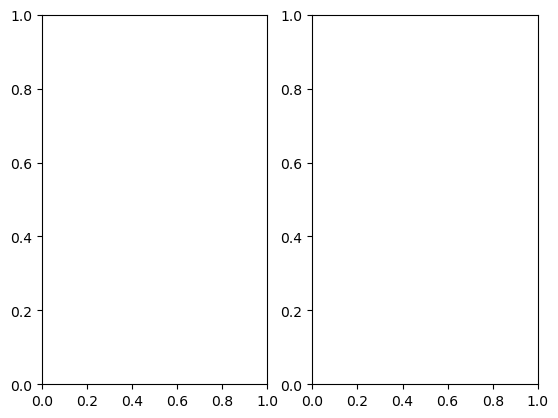

In [3]:
lab_nums = torch.Tensor(val_dataset.data_frame['label_number'].to_numpy()).long().cuda()
batch_sz = 64
dataloader = DataLoader(
        val_dataset,
        batch_size = batch_sz,
        shuffle = False,
        num_workers = 0,
        pin_memory = True)
        
class_dice_collector = []

fig, ax = plt.subplots(1,2)
for step, (image_embedding, gt2D, boxes, slice_names) in enumerate(tqdm(dataloader)):

        label_numbers = lab_nums[batch_sz*step:batch_sz*(step+1)]
        image_embedding, gt2D, boxes = image_embedding.cuda(), gt2D.cuda(), boxes.cuda()
        medsam_pred = torch.as_tensor(medsam_inference(sam_model, image_embedding, boxes, 256, 256, as_one_hot=True, model_trained_on_multi_label=False), dtype=torch.uint8).cuda()
        pred = medsam_pred[:,0:1,:,:] # B, 103, H, W -> B, 1, H, W
        

        subset_gt = torch.take_along_dim(gt2D, label_numbers[:, None, None, None], dim=1).long()
        dice_scores = dice_scores_multi_class(pred, subset_gt, eps=1e-6) # (B, C)
        class_dice_collector.append(dice_scores)


#medsam_inference(medsam_model, img_embed, box_1024, H, W, as_one_hot, model_trained_on_multi_label=True)


tensor(595188, device='cuda:0')